In [58]:
import seaborn as sns
from pyspark.sql import SparkSession, functions, Window

In [2]:
def get_session():
    return SparkSession \
        .builder \
        .appName('Market Analytics') \
        .getOrCreate()

In [3]:
sess = get_session()

## Overview datasets

In [4]:
!ls -l dataset/Stocks | head

total 1373216
-rwxr-xr-x@ 1 faisal  staff  223899 Nov 13  2017 a.us.txt
-rwxr-xr-x@ 1 faisal  staff  593692 Nov 13  2017 aa.us.txt
-rwxr-xr-x@ 1 faisal  staff   21911 Nov 13  2017 aaap.us.txt
-rwxr-xr-x@ 1 faisal  staff  246552 Nov 13  2017 aaba.us.txt
-rwxr-xr-x@ 1 faisal  staff   33723 Nov 13  2017 aac.us.txt
-rwxr-xr-x@ 1 faisal  staff   49499 Nov 13  2017 aal.us.txt
-rwxr-xr-x@ 1 faisal  staff   50642 Nov 13  2017 aamc.us.txt
-rwxr-xr-x@ 1 faisal  staff  135301 Nov 13  2017 aame.us.txt
-rwxr-xr-x@ 1 faisal  staff  155628 Nov 13  2017 aan.us.txt


In [5]:
!cat dataset/Stocks/aac.us.txt | head

In [6]:
!du -sh .

1.3G	.


## Load Datasets

In [7]:
@functions.udf
def extract_symbol(filename):
    return filename.split('/')[-1].split('.')[0]

def load_data(session):
    df = session.read.format('csv').option('header', 'true').load('dataset/Stocks/*.txt')
    df = df.drop('OpenInt')
    df = df.withColumn('Symbol', extract_symbol(functions.input_file_name()))
    df = df.withColumn('Date', df['Date'].cast('date'))
    df = df.withColumn('Open', df['Open'].cast('float'))
    df = df.withColumn('High', df['High'].cast('float'))
    df = df.withColumn('Low', df['Low'].cast('float'))
    df = df.withColumn('Close', df['Close'].cast('float'))
    return df

In [8]:
load = load_data(sess)
load.show(10)

+----------+------+------+------+------+-------+------+
|      Date|  Open|  High|   Low| Close| Volume|Symbol|
+----------+------+------+------+------+-------+------+
|1962-01-02|0.6277|0.6362|0.6201|0.6201|2575579|    ge|
|1962-01-03|0.6201|0.6201|0.6122|0.6201|1764749|    ge|
|1962-01-04|0.6201|0.6201|0.6037|0.6122|2194010|    ge|
|1962-01-05|0.6122|0.6122|0.5798|0.5957|3255244|    ge|
|1962-01-08|0.5957|0.5957|0.5716|0.5957|3696430|    ge|
|1962-01-09|0.5957|0.6037|0.5878|0.5957|2778285|    ge|
|1962-01-10|0.5957|0.6037|0.5957|0.5957|2337096|    ge|
|1962-01-11|0.5957|0.5957|0.5878|0.5957|1943605|    ge|
|1962-01-12|0.5957|0.6037|0.5878|0.5878|2015151|    ge|
|1962-01-15|0.5957|0.5957|0.5957|0.5957|2527879|    ge|
+----------+------+------+------+------+-------+------+
only showing top 10 rows



## Technical Indicator

### Moving Average

In [60]:
days = lambda i: i * 86400 

def moving_average(df, symbol, day):
    df = df.where(df['Symbol'] == symbol.lower())
    
    w = (Window()
         .orderBy(functions.unix_timestamp(df['Date']))
         .rangeBetween(-days(day), 0))

    return df.withColumn('MA', functions.avg('Close').over(w))

In [79]:
# moving averang 100, symbol aapl (Apple)
aapl = moving_average(load, 'aapl', 100)
aapl.show(5)

+----------+-------+-------+-------+-------+--------+------+-------------------+
|      Date|   Open|   High|    Low|  Close|  Volume|Symbol|                 MA|
+----------+-------+-------+-------+-------+--------+------+-------------------+
|1984-09-07|0.42388|0.42902|0.41874|0.42388|23220030|  aapl|  0.423880010843277|
|1984-09-10|0.42388|0.42516|0.41366|0.42134|18022532|  aapl|0.42260999977588654|
|1984-09-11|0.42516|0.43668|0.42516|0.42902|42498199|  aapl|0.42474666237831116|
|1984-09-12|0.42902|0.43157|0.41618|0.41618|37125801|  aapl|  0.422605000436306|
|1984-09-13|0.43927|0.44052|0.43927|0.43927|57822062|  aapl| 0.4259379982948303|
+----------+-------+-------+-------+-------+--------+------+-------------------+
only showing top 5 rows



In [80]:
def graph_ma(df):
    sns.lineplot(data=df, palette="tab10", linewidth=2.5)

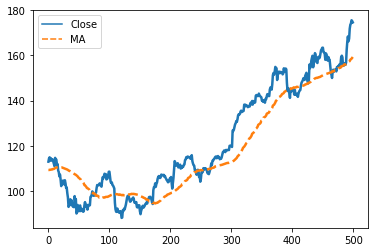

In [81]:
pandas = aapl.select('Close', 'MA').orderBy(aapl['Date'].desc()).limit(500).orderBy(aapl['Date']).toPandas()
graph_ma(pandas)